# Importing and Stuff

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(42)

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the mapping of each letter

abc = 'abcdefghijklmnopqrstuvwxyz'
stoi = {s: i+1 for i, s in enumerate(abc)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [6]:
block_size = 3

# build the databse
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# training, dev and test split
# 80%   10%   10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Neural Net

## Spread out

In [7]:
# All the parameters
n_embd = 10    # the dimensionality of the character embedding vector
n_hidden = 200    # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embd),                     generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * ((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01    # because of bn, there is no effect of this bias
W2 = torch.randn((n_hidden, 27),                  generator=g) * 0.01
b2 = torch.randn(27,                              generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print('We have', sum([p.nelement() for p in parameters]), 'number of parameters!')

We have 12097 number of parameters!


In [8]:
max_steps = 2_00_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]    # Batch X, Y

    # Forward Pass
    emb = C[Xb]    # Embed the chars into vectors
    embcat = emb.view(emb.shape[0], -1)    # concatenates the vectors
    hpreact = embcat @ W1    # + b1 (no effect of b1 because of hpreact - bnmeani)    # hiddlen layer pre-ctivation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias    # batch normalisation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias    # batch normalisation
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)    # hidden layer
    logits = h @ W2 + b2    # output layer
    loss = F.cross_entropy(logits, Yb)    # loss function
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break


      0 /  200000: 3.3239
  10000 /  200000: 2.1080
  20000 /  200000: 2.7056
  30000 /  200000: 2.1581
  40000 /  200000: 2.3510
  50000 /  200000: 1.9673
  60000 /  200000: 2.2058
  70000 /  200000: 2.4311
  80000 /  200000: 2.6161
  90000 /  200000: 2.2592
 100000 /  200000: 2.3973
 110000 /  200000: 2.4511
 120000 /  200000: 1.7488
 130000 /  200000: 2.1158
 140000 /  200000: 2.4020
 150000 /  200000: 2.1161
 160000 /  200000: 2.0824
 170000 /  200000: 2.3950
 180000 /  200000: 2.1838
 190000 /  200000: 2.1770


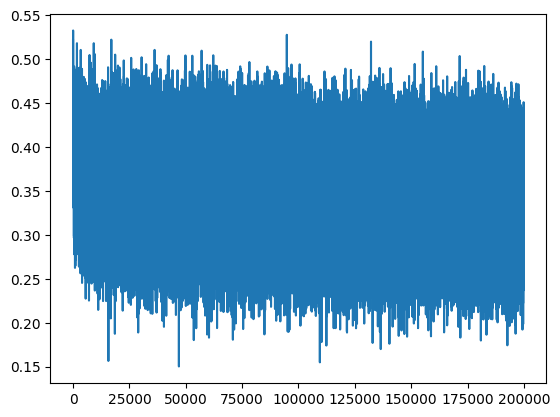

In [9]:
# use the graph to see good learning rates
plt.plot(lossi)

In [10]:
@torch.no_grad    # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]    # shpae -> (N, block_size, n_emb)
    embcat = emb.view(emb.shape[0], -1)    # shpae -> (N, block_size * n_emb)
    hpreact = embcat @ W1 # + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias    # batch normalisation
    # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias    # batch normalisation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias    # batch normalisation
    h = torch.tanh(hpreact)    # shpae -> (N, n_hidden)
    logits = h @ W2 + b2    # shpae -> (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.1734328269958496
dev 2.187385082244873


In [11]:
# Sampling from the model

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor([context])]
        # h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(itos[ix])

        # break if '.' is recieved
        if ix == 0:
            break
    print(''.join(out))    # convert array to string


luckr.
pnlssannesstevangruk.
lbizmnhxhmallerggen.
thuk.
boy.


## Cleaned Up

In [12]:
# All the parameters
n_embd = 10    # the dimensionality of the character embedding vector
n_hidden = 200    # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embd),                     generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * ((n_embd * block_size)**0.5)
W2 = torch.randn((n_hidden, 27),                  generator=g) * 0.01
b2 = torch.randn(27,                              generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print('We have', sum([p.nelement() for p in parameters]), 'number of parameters!')

We have 12097 number of parameters!


In [13]:
max_steps = 2_00_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # 1) Construct Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]    # Batch X, Y

    # 2) Forward Pass
    # 2.1) Input vectors
    emb = C[Xb]    # Embed the chars into vectors
    embcat = emb.view(emb.shape[0], -1)    # concatenates the vectors
    # 2.2) Linear Layer
    hpreact = embcat @ W1    # + b1 (no effect of b1 because of hpreact - bnmeani)    # hiddlen layer pre-ctivation

    # 2.3) BatchNorm Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias    # batch normalisation
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # 2.4) Non-Linearity
    h = torch.tanh(hpreact)    # hidden layer
    logits = h @ W2 + b2    # output layer
    loss = F.cross_entropy(logits, Yb)    # loss function
    
    # 3) Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 4) Update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # 5) track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0 /  200000: 3.3239
  10000 /  200000: 2.1080
  20000 /  200000: 2.7056
  30000 /  200000: 2.1581
  40000 /  200000: 2.3510
  50000 /  200000: 1.9673
  60000 /  200000: 2.2058
  70000 /  200000: 2.4311
  80000 /  200000: 2.6161
  90000 /  200000: 2.2592
 100000 /  200000: 2.3973
 110000 /  200000: 2.4511
 120000 /  200000: 1.7488
 130000 /  200000: 2.1158
 140000 /  200000: 2.4020
 150000 /  200000: 2.1161
 160000 /  200000: 2.0824
 170000 /  200000: 2.3950
 180000 /  200000: 2.1838
 190000 /  200000: 2.1770


In [14]:
@torch.no_grad()    # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]    # shpae -> (N, block_size, n_emb)
    embcat = emb.view(emb.shape[0], -1)    # shpae -> (N, block_size * n_emb)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias    # batch normalisation
    h = torch.tanh(hpreact)    # shpae -> (N, n_hidden)
    logits = h @ W2 + b2    # shpae -> (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.1734328269958496
dev 2.187385082244873
